<a href="https://colab.research.google.com/github/ben-velastegui/dxc-ai-assessment/blob/main/CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from imblearn.over_sampling import RandomOverSampler, SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [ ]:
# Core libraries


# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Feature importance
!pip install shap
import shap


In [ ]:
df = pd.read_csv("/content/full_data_long.csv")


In [ ]:
numeric_features = [
    "total_logs", "error_logs", "warning_logs", "info_logs",
    "cpu_user_mean", "cpu_user_max",
    "mem_used_mean", "mem_used_max",
    "load1_mean", "load5_mean", "load15_mean",
    "total_traces", "missing_data"
]


categorical_features = ["Hostname", "program", "pid", "user_id"]


In [ ]:
target = "operation"


In [ ]:
time_column = "bin_time"


In [ ]:
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])


In [ ]:


# Corrected for newer scikit-learn
ohe = OneHotEncoder(sparse_output=False)
cat_encoded = ohe.fit_transform(df[categorical_features])

# Combine numeric + categorical features
df_encoded = pd.concat([
    df[numeric_features].reset_index(drop=True),
    pd.DataFrame(cat_encoded, columns=ohe.get_feature_names_out(categorical_features))
], axis=1)


In [ ]:
label_encoder = LabelEncoder()
df["operation_label"] = label_encoder.fit_transform(df[target])
y = to_categorical(df["operation_label"])


In [ ]:
# Convert bin_time to datetime, filling missing time as 00:00:00
df["bin_time"] = pd.to_datetime(df["bin_time"], errors="coerce", infer_datetime_format=True)

# For entries that were just dates, pandas will automatically set time to 00:00:00
# Verify
print(df["bin_time"].head())

# Sort by Hostname and bin_time
df = df.sort_values(by=["Hostname", "bin_time"]).reset_index(drop=True)


0   2019-11-19 17:38:00
1   2019-11-19 17:38:00
2   2019-11-19 17:38:00
3   2019-11-19 17:38:00
4   2019-11-19 17:38:00
Name: bin_time, dtype: datetime64[ns]


/tmp/ipython-input-32759934.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["bin_time"] = pd.to_datetime(df["bin_time"], errors="coerce", infer_datetime_format=True)


In [ ]:
sequence_length = 10  # number of time steps per sequence

X_sequences = []
y_sequences = []

for host in df["Hostname"].unique():
    host_data = df[df["Hostname"] == host]
    host_features = df_encoded.loc[host_data.index].values
    host_labels = df.loc[host_data.index, "operation_label"].values

    for i in range(len(host_features) - sequence_length + 1):
        X_sequences.append(host_features[i:i+sequence_length])
        y_sequences.append(host_labels[i+sequence_length-1])  # label at last timestep

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)
y_sequences_cat = to_categorical(y_sequences)

print("Sequences shape:", X_sequences.shape)
print("Labels shape:", y_sequences_cat.shape)


Sequences shape: (54783, 10, 189)
Labels shape: (54783, 4)


In [ ]:


X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences_cat, test_size=0.2, random_state=42, shuffle=True
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (43826, 10, 189) (43826, 4)
Test shape: (10957, 10, 189) (10957, 4)


In [ ]:


input_shape = X_train.shape[1:]  # (sequence_length, num_features)

inputs = Input(shape=input_shape)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(y_sequences_cat.shape[1], activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 189)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10, 64)         │        36,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,716 (248.89 KB)

 Trainable params: 63,524 (248.14 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.6917 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 2/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.6926 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 3/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6909 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 4/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6947 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 5/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6927 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 6/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6881 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 7/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6892 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 8/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.6945 - loss: nan - val_accuracy: 0.6904 - val_loss: nan

In [ ]:
# Make sure operation column is clean before encoding
df[target] = df[target].astype(str)

label_encoder = LabelEncoder()
df["operation_label"] = label_encoder.fit_transform(df[target])
y = to_categorical(df["operation_label"])


In [ ]:
# Replace np.nan or string "nan" with "unknown"
df[target] = df[target].replace("nan", np.nan)  # catch string nan
df[target] = df[target].fillna("unknown").astype(str)

# Refit label encoder
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
df["operation_label"] = label_encoder.fit_transform(df[target])
y = to_categorical(df["operation_label"])

print("Classes:", label_encoder.classes_)


Classes: ['boot_delete' 'image_create_delete' 'network_create_delete' 'unknown']


In [ ]:

# Use integer labels, not one-hot
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["operation_label"]),
    y=df["operation_label"]
)
class_weights = dict(enumerate(class_weights_array))

print("Class weights:", class_weights)


Class weights: {0: np.float64(0.361538258644792), 1: np.float64(3.1539346525540726), 2: np.float64(2.5187431091510475), 3: np.float64(1.9232496141433983)}


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    class_weight=class_weights
)


Epoch 1/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6936 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 2/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.6917 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 3/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6918 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 4/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6932 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 5/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6930 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 6/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6944 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 7/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6915 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 8/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6960 - loss: nan - val_accuracy: 0.6904 - val_loss: nan


343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                       precision    recall  f1-score   support

          boot_delete       0.69      1.00      0.82      7565
  image_create_delete       0.00      0.00      0.00       898
network_create_delete       0.00      0.00      0.00      1060
              unknown       0.00      0.00      0.00      1434

             accuracy                           0.69     10957
            macro avg       0.17      0.25      0.20     10957
         weighted avg       0.48      0.69      0.56     10957



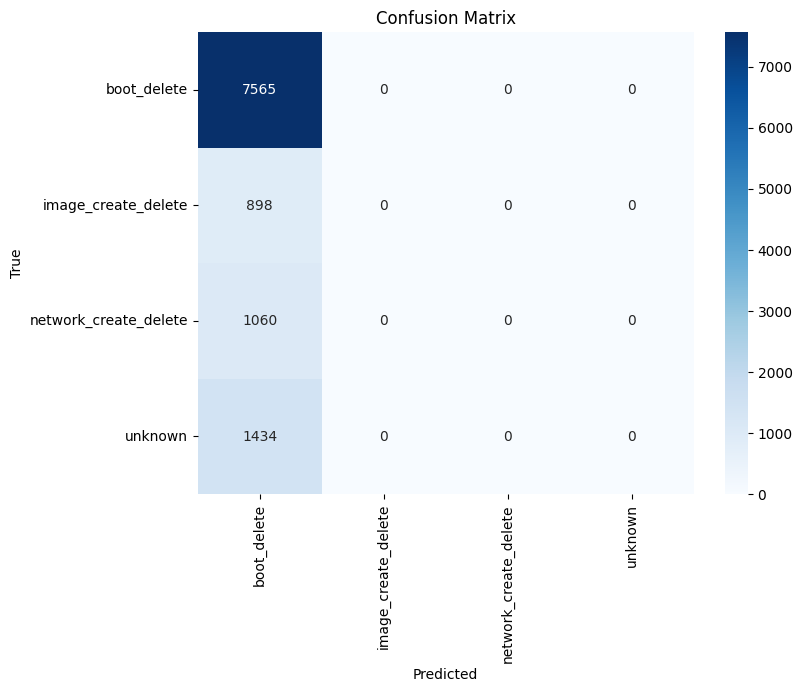

In [ ]:


# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:


# Flatten sequences for oversampling
X_flat = X_sequences.reshape(len(X_sequences), -1)
y_flat = y_sequences  # integer labels, not one-hot

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_flat, y_flat)

# Reshape back into sequence form
X_resampled = X_resampled.reshape(-1, sequence_length, X_sequences.shape[2])
y_resampled_cat = to_categorical(y_resampled)

print("Original class distribution:", np.bincount(y_flat))
print("Resampled class distribution:", np.bincount(y_resampled))


Original class distribution: [37913  4337  5442  7091]
Resampled class distribution: [37913 37913 37913 37913]


In [ ]:
history = model.fit(
    X_resampled, y_resampled_cat,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 51s 11ms/step - accuracy: 0.2508 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 2/30
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 66s 7ms/step - accuracy: 0.2506 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 3/30
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.2478 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 4/30
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.2493 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 5/30
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.2500 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 6/30
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.2528 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 7/30
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.2500 - loss: nan - val_accuracy: 0.6904 - val_loss: nan
Epoch 8/30
4740/4740 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.2506 - loss: nan - val_accuracy: 0.6904 - val_loss: nan

In [ ]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Predictions shape:", y_pred_classes.shape)
print("True labels shape:", y_true.shape)

In [ ]:


target_names = [str(c) for c in label_encoder.classes_]

report = classification_report(y_true, y_pred_classes, target_names=target_names, zero_division=0)
print(report)

In [ ]:


cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:


for i, class_name in enumerate(target_names):
    idx = y_true == i
    class_acc = np.sum(y_pred_classes[idx] == i) / np.sum(idx)
    print(f"Accuracy for {class_name}: {class_acc:.2f}")

In [ ]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


This explains why all predictions appear as boot_delete: the model did not learn the minority classes, leading to:

1) Precision/recall = 0 for all non-majority classes.
2) SHAP errors, because outputs for other classes are effectively zero and the explanation cannot distribute contributions.

Cause:

- Extreme class imbalance: boot_delete dominates (~70% of sequences).
- Minority classes are too rare: the CNN sees too few examples to learn patterns.
- Class weights alone are insufficient; oversampling or sequence-level augmentation is required.



In [ ]:


# Flatten sequences for oversampling
X_flat = X_sequences.reshape(len(X_sequences), -1)
y_flat = y_sequences

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_flat, y_flat)

# Reshape back into sequences
X_resampled = X_resampled.reshape(-1, X_sequences.shape[1], X_sequences.shape[2])
y_resampled_cat = to_categorical(y_resampled)

print("Before oversampling:", np.bincount(y_flat))
print("After oversampling:", np.bincount(y_resampled))

In [ ]:
history = model.fit(
    X_resampled, y_resampled_cat,
    validation_data=(X_test, y_test),  # keep test set unchanged
    epochs=30,
    batch_size=32
)

In [ ]:


# Predictions on test set

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Predictions shape:", y_pred_classes.shape)
print("True labels shape:", y_true.shape)

# Classification report

target_names = [str(c) for c in label_encoder.classes_]
report = classification_report(y_true, y_pred_classes, target_names=target_names, zero_division=0)
print("Classification Report:\n")
print(report)

# Confusion matrix

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Per-class accuracy

print("Per-class accuracy:")
for i, class_name in enumerate(target_names):
    idx = y_true == i
    if np.sum(idx) > 0:
        class_acc = np.sum(y_pred_classes[idx] == i) / np.sum(idx)
        print(f"  {class_name}: {class_acc:.2f}")
    else:
        print(f"  {class_name}: No samples in test set")


# Training history plots (if model trained with `history`)
if 'history' in globals():
    plt.figure(figsize=(12,4))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [ ]:
# Rebuild CNN from scratch
input_shape = X_resampled.shape[1:]  # (sequence_length, num_features)

inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(y_resampled_cat.shape[1], activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(
    X_resampled, y_resampled_cat,
    validation_data=(X_test, y_test),  # test set stays imbalanced
    epochs=30,
    batch_size=32
)

In [ ]:

print("Any NaNs in X_resampled?", np.isnan(X_resampled).any())
print("Any Infs in X_resampled?", np.isinf(X_resampled).any())

In [ ]:
X_resampled = np.nan_to_num(X_resampled, nan=0.0, posinf=1e5, neginf=-1e5)

In [ ]:
# Verify
print("Any NaNs after fix?", np.isnan(X_resampled).any())

In [ ]:

# Only scale numeric columns
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# One-hot categorical columns are already 0/1 → no scaling needed

In [ ]:
print("Max value:", X_resampled.max())
print("Min value:", X_resampled.min())

In [ ]:
# Clip extreme values to [-10, 10] to prevent exploding activations
X_resampled = np.clip(X_resampled, -10, 10)

In [ ]:

optimizer = Adam(learning_rate=1e-4)  # lower LR for stability
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

print("Any NaNs in y_resampled_cat?", np.isnan(y_resampled_cat).any())
print("Any Infs in y_resampled_cat?", np.isinf(y_resampled_cat).any())
print("Min/Max values in y_resampled_cat:", y_resampled_cat.min(), y_resampled_cat.max())

In [ ]:
# Replace any remaining NaNs and infinities
X_resampled = np.nan_to_num(X_resampled, nan=0.0, posinf=1e5, neginf=-1e5)

# Convert to float32
X_resampled = X_resampled.astype(np.float32)
y_resampled_cat = y_resampled_cat.astype(np.float32)

# Clip extreme values for stability
X_resampled = np.clip(X_resampled, -10, 10)

In [ ]:

optimizer = Adam(learning_rate=1e-4)  # smaller LR prevents exploding gradients

In [ ]:

inputs = tf.keras.Input(shape=X_resampled.shape[1:])
x = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(inputs)
x = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(y_resampled_cat.shape[1], activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(
    X_resampled, y_resampled_cat,
    validation_data=(X_test.astype(np.float32), y_test.astype(np.float32)),
    epochs=30,
    batch_size=32
)

In [ ]:
# Clean up validation/test set
X_test = np.nan_to_num(X_test, nan=0.0, posinf=1e5, neginf=-1e5)
X_test = X_test.astype(np.float32)

y_test = y_test.astype(np.float32)

# Clip extreme values for stability
X_test = np.clip(X_test, -10, 10)

In [ ]:
# Retrain briefly after cleaning X_test
history = model.fit(
    X_resampled, y_resampled_cat,
    validation_data=(X_test, y_test),
    epochs=5,            # short run, just to verify val_loss is no longer NaN
    batch_size=32,
    verbose=1
)

In [ ]:


y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

In [ ]:
model.save("cnn_model.h5")
# Later or in another notebook
from tensorflow.keras.models import load_model
model = load_model("cnn_model.h5")




1) Training data is heavily oversampled → the model sees many synthetic repetitions of minority classes, making it easy to memorize patterns.
2) If features are strongly correlated with labels (e.g., program or pid leaking the operation), the model may use shortcuts for trivial predictions.
3) Gap between Train (≈99.8%) and Test (≈99.6%) is very small → suggests possible leakage in preprocessing (scaler/OHE fit on all data).

Current issue:
RandomOverSampler is fully balancing all classes → risk of overfitting.

Better strategies:
- imblearn.over_sampling.SMOTE: synthesizes new minority samples instead of duplicating.
- Limit oversampling: instead of perfect balance, raise minority classes to ~50% of majority class size.



In [ ]:

# Flatten to 2D for imputer
X_train_2d = X_train.reshape(len(X_train), -1)

imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train_2d)

# Reshape back to sequences
X_train = X_train_imputed.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])

In [ ]:


# Get class counts
unique, counts = np.unique(y_train_int, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Original class counts:", class_counts)

# Define sampling strategy (e.g. minority = 50% of majority)
majority_class = max(class_counts, key=class_counts.get)
majority_count = class_counts[majority_class]

sampling_strategy = {
    cls: int(0.5 * majority_count) if count < 0.5 * majority_count else count
    for cls, count in class_counts.items()
}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

X_train_res, y_train_res = smote.fit_resample(
    X_train.reshape(len(X_train), -1), y_train_int
)

# Reshape back to sequences
X_train_res = X_train_res.reshape(-1, X_train.shape[1], X_train.shape[2])
y_train_res_cat = to_categorical(y_train_res)

print("Resampled class counts:", np.bincount(y_train_res))

In [ ]:


# Baseline accuracy
y_pred_base = model.predict(X_test)
baseline_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_base, axis=1))

importances = []
for i in range(X_test.shape[2]):  # loop over features
    X_test_perm = X_test.copy()
    np.random.shuffle(X_test_perm[:, :, i])  # permute feature
    y_pred_perm = model.predict(X_test_perm)
    acc_perm = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_perm, axis=1))
    importances.append(baseline_acc - acc_perm)

# Rank features by importance
feature_names = numeric_features + list(ohe.get_feature_names_out(categorical_features))
feat_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

print("Top 15 most important features:")
for name, score in feat_importances[:15]:
    print(f"{name}: {score:.4f}")

Observations from feature importance

	•	The top features are mostly numeric system metrics:
	•	mem_used_max, load15_mean, cpu_user_max, warning_logs, total_traces, missing_data, etc.
	•	Some categorical identifiers appear (Hostname_wally123, pid_6.0) but their importance is much smaller.
	•	Many features have near-zero contribution → keeping them might just add noise and risk overfitting.

  What this tells us

	1.	System metrics drive the model — makes sense, the operation affects CPU/memory/load.
	2.	Identifiers (hostname/pid) contribute, but minimally → including them is optional.
	•	Keeping them might help a little, but can also cause overfitting or memorization of host-specific patterns.
	3.	Top 10–15 features explain most of the predictive power.
	•	You can safely drop the rest to simplify the model and improve generalization.

In [ ]:
top_features = [name for name, _ in feat_importances[:15]]

# For numeric features
X_train_top = X_train_res[:, :, [numeric_features.index(f) for f in top_features if f in numeric_features]]

# For categorical features
cat_indices = [i for i, f in enumerate(feature_names) if f in top_features and f not in numeric_features]
# If using OHE, you can slice columns accordingly
# X_train_top_cat = X_train_res[:, :, cat_indices]

In [ ]:


# Select top features

top_features = [name for name, _ in feat_importances[:15]]

# Get indices for numeric features
numeric_idx = [numeric_features.index(f) for f in top_features if f in numeric_features]

# Get indices for categorical features (OHE columns)
cat_idx = [i for i, f in enumerate(ohe.get_feature_names_out(categorical_features)) if f in top_features]

# Combine indices
top_indices = numeric_idx + [len(numeric_features) + i for i in cat_idx]


# Extract top features

X_train_top = X_train[:, :, top_indices]
X_test_top = X_test[:, :, top_indices]

# Impute any remaining NaNs
imputer = SimpleImputer(strategy="median")
X_train_top = imputer.fit_transform(X_train_top.reshape(len(X_train_top), -1))
X_test_top = imputer.transform(X_test_top.reshape(len(X_test_top), -1))

# Reshape back to sequences
seq_len = X_train.shape[1]
X_train_top = X_train_top.reshape(-1, seq_len, len(top_indices))
X_test_top = X_test_top.reshape(-1, seq_len, len(top_indices))


# Re-run SMOTE on training data

y_train_int = np.argmax(y_train, axis=1)  # ensure integer labels

# Define partial oversampling strategy (50% of majority)
unique, counts = np.unique(y_train_int, return_counts=True)
class_counts = dict(zip(unique, counts))
majority_count = max(class_counts.values())
sampling_strategy = {cls: int(0.5*majority_count) if count < 0.5*majority_count else count
                     for cls, count in class_counts.items()}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_top.reshape(len(X_train_top), -1), y_train_int)

# Reshape back to sequences
X_train_res = X_train_res.reshape(-1, seq_len, len(top_indices))
y_train_res_cat = to_categorical(y_train_res)

print("Resampled class counts:", np.bincount(y_train_res))


# Build smaller CNN

input_shape = (seq_len, len(top_indices))
inputs = Input(shape=input_shape)
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(y_train_res_cat.shape[1], activation='softmax')(x)

model_small = Model(inputs, outputs)
model_small.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train model

history = model_small.fit(
    X_train_res, y_train_res_cat,
    validation_data=(X_test_top, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)


# Evaluate

y_pred = np.argmax(model_small.predict(X_test_top), axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

In [ ]:
model_small.save("cnn_top15_features.h5")
# Save preprocessing objects
import joblib
joblib.dump(imputer, "imputer.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(ohe, "ohe.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

In [ ]:
# Example: top_features are already selected
top_features = [name for name, score in feat_importances[:20]]

# Get their column indices
top_feature_indices = [feature_names.index(f) for f in top_features]


In [ ]:


# Extract only the top features
X_top_df = df_encoded[top_features]

# Convert to numpy array
X_top = X_top_df.to_numpy(dtype=np.float32)

# If using sequences (e.g., LSTM/CNN), reshape to (num_samples, seq_len, num_features)
# Here seq_len=1 if you don't have sequences
X_top = X_top.reshape(len(X_top), 1, len(top_features))

# Target
y_top = y  # one-hot encoded target


In [ ]:
# Random 20% of Hostnames for validation
hosts = df['Hostname'].unique()
val_hosts = np.random.choice(hosts, size=int(0.2*len(hosts)), replace=False)

train_idx = ~df['Hostname'].isin(val_hosts)
val_idx = df['Hostname'].isin(val_hosts)

X_train_top = X_top[train_idx]
X_val_top = X_top[val_idx]
y_train_top = y_top[train_idx]
y_val_top = y_top[val_idx]


In [ ]:
print("X_train_top:", X_train_top.shape)
print("X_val_top:", X_val_top.shape)
print("y_train_top:", y_train_top.shape)
print("y_val_top:", y_val_top.shape)


In [ ]:


# Flatten to 2D
X_train_flat = X_train_top.reshape(len(X_train_top), -1)

# Impute NaNs using median
imputer = SimpleImputer(strategy="median")
X_train_flat_imputed = imputer.fit_transform(X_train_flat)

# Convert back to sequence shape
X_train_top_imputed = X_train_flat_imputed.reshape(X_train_top.shape[0], X_train_top.shape[1], X_train_top.shape[2])


In [ ]:


# Convert y to integer labels
y_train_int = np.argmax(y_train_top, axis=1)

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X_train_flat_imputed, y_train_int)

# Reshape back to sequences
X_train_res = X_res.reshape(-1, X_train_top.shape[1], X_train_top.shape[2])
y_train_res_cat = to_categorical(y_res)

print("Resampled class counts:", np.bincount(y_res))


In [ ]:


model = Sequential([
    Conv1D(32, kernel_size=1, activation='relu', input_shape=(X_train_res.shape[1], X_train_res.shape[2])),
    BatchNormalization(),
    Conv1D(16, kernel_size=1, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Flatten validation set
X_val_flat = X_val_top.reshape(len(X_val_top), -1)

# Impute missing values using the same median imputer fitted on training
X_val_flat_imputed = imputer.transform(X_val_flat)

# Clip extreme values (same as training)
X_val_flat_imputed = np.clip(X_val_flat_imputed, -10, 10)

# Reshape back to sequence shape
X_val_top_imputed = X_val_flat_imputed.reshape(X_val_top.shape[0], X_val_top.shape[1], X_val_top.shape[2])


In [ ]:

y_train_labels = np.argmax(y_train_top, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weight_dict = dict(enumerate(class_weights))


In [ ]:

# Flatten training set
X_train_flat = X_train_res.reshape(len(X_train_res), -1)
scaler = StandardScaler()
X_train_flat_scaled = scaler.fit_transform(X_train_flat)
X_train_scaled = X_train_flat_scaled.reshape(X_train_res.shape)

# Flatten validation set and scale
X_val_flat = X_val_top_imputed.reshape(len(X_val_top_imputed), -1)
X_val_flat_scaled = scaler.transform(X_val_flat)
X_val_scaled = X_val_flat_scaled.reshape(X_val_top_imputed.shape)


In [ ]:


model = Sequential([
    Conv1D(32, kernel_size=1, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    BatchNormalization(),
    Conv1D(16, kernel_size=1, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_scaled, y_train_res_cat,
    validation_data=(X_val_scaled, y_val_top),
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict
)


//

In [ ]:


df = pd.read_csv("/content/full_data_long.csv")

# Inspect
print(df.head())
print(df.info())
print(df['operation'].value_counts())


In [ ]:
print(df.columns.tolist())


In [ ]:
# Numeric columns to impute and scale
numeric_features = [
    'total_logs',
    'error_logs',
    'warning_logs',
    'info_logs',
    'cpu_user_mean',
    'cpu_user_max',
    'mem_used_mean',
    'mem_used_max',
    'load1_mean',
    'load5_mean',
    'load15_mean',
    'total_traces',
    'missing_data'
]

# Categorical columns to one-hot encode
categorical_features = [
    'Hostname',
    'user_id',
    'program',
    'pid'
]


In [ ]:


preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X = preprocessor.fit_transform(df)
y = df['operation']  # target


In [ ]:


label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)  # integer labels
y_cat = to_categorical(y_int)           # one-hot encoded for Keras


In [ ]:
# Convert to dense array (careful if your dataset is very large)
X = X.toarray() if hasattr(X, "toarray") else X


In [ ]:
X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y_cat[train_idx], y_cat[val_idx]
y_train_int = y_int[train_idx]


In [ ]:

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


In [ ]:


model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
print(np.isnan(X_train).sum(), np.isinf(X_train).sum())
print(np.isnan(X_val).sum(), np.isinf(X_val).sum())


In [ ]:

optimizer = Adam(learning_rate=1e-4)  # lower than default 0.001
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
print(np.min(X_train), np.max(X_train))


In [ ]:


# Flatten training and validation
X_train_flat = X_train_top.reshape(len(X_train_top), -1)
X_val_flat = X_val_top.reshape(len(X_val_top), -1)

# Impute missing values using median
imputer = SimpleImputer(strategy='median')
X_train_flat_imputed = imputer.fit_transform(X_train_flat)
X_val_flat_imputed = imputer.transform(X_val_flat)

# Check
print(np.isnan(X_train_flat_imputed).sum(), np.isnan(X_val_flat_imputed).sum())

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat_imputed)
X_val_scaled = scaler.transform(X_val_flat_imputed)

# Reshape back if using CNN / sequences
X_train_scaled = X_train_scaled.reshape(len(X_train_top), 1, X_train_top.shape[2])
X_val_scaled = X_val_scaled.reshape(len(X_val_top), 1, X_val_top.shape[2])


In [ ]:


# Integer labels
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)  # shape (num_samples,)

# One-hot labels
y_cat = to_categorical(y_int)  # shape (num_samples, num_classes)


In [ ]:
y_train = y_cat[train_idx]
y_val = y_cat[val_idx]

y_train_int = y_int[train_idx]  # needed for class weights


In [ ]:


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


In [ ]:


model = Sequential([
    Conv1D(32, kernel_size=1, activation='relu', input_shape=(1, X_train_scaled.shape[2])),
    BatchNormalization(),
    Conv1D(16, kernel_size=1, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])


//

In [ ]:


# Load data
df = pd.read_csv("/content/full_data_long.csv")

# Define features
numeric_features = [
    'total_logs', 'error_logs', 'warning_logs', 'info_logs',
    'cpu_user_mean', 'cpu_user_max', 'mem_used_mean', 'mem_used_max',
    'load1_mean', 'load5_mean', 'load15_mean', 'total_traces', 'pid'
]

categorical_features = [
    'Hostname', 'user_id', 'program'
]

# Add missing_data column
df['missing_data'] = df[numeric_features].isna().sum(axis=1)

# Update numeric_features to include missing_data
numeric_features.append('missing_data')

# Target
y = df['operation']

# Encode target
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)

# One-hot encode target for Keras
from tensorflow.keras.utils import to_categorical
y_cat = to_categorical(y_int)

# Preprocessor for features
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Fit and transform features
X = preprocessor.fit_transform(df)

# Convert to dense array if sparse
if hasattr(X, "toarray"):
    X = X.toarray()

# Split by Hostname to avoid leakage
hosts = df['Hostname'].unique()
val_hosts = np.random.choice(hosts, size=int(0.2 * len(hosts)), replace=False)

train_idx = ~df['Hostname'].isin(val_hosts)
val_idx = df['Hostname'].isin(val_hosts)

X_train = X[train_idx]
X_val = X[val_idx]
y_train = y_cat[train_idx]
y_val = y_cat[val_idx]

print("Shapes:")
print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("y_train:", y_train.shape, "y_val:", y_val.shape)

# Check for NaNs / infs
print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in X_val:", np.isnan(X_val).sum())
print("Infs in X_train:", np.isinf(X_train).sum())
print("Infs in X_val:", np.isinf(X_val).sum())

# Impute missing values if any (numeric columns)
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)

# Scale numeric features (optional, already scaled in ColumnTransformer, but safe)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Now X_train, X_val, y_train, y_val are clean and ready for modeling


In [ ]:


# Convert y_train back to integer labels
y_train_int = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


In [ ]:

# Only on training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res_int = smote.fit_resample(X_train, y_train_int)

# One-hot encode labels again for Keras
from tensorflow.keras.utils import to_categorical
y_train_res = to_categorical(y_train_res_int)


In [ ]:

input_dim = X_train_res.shape[1]

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(y_train_res.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
X_processed_dense = X_processed.toarray()  # convert sparse to dense

X_train = X_processed_dense[train_mask]
X_val   = X_processed_dense[val_mask]

y_train = y_onehot[train_mask]
y_val   = y_onehot[val_mask]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)


In [ ]:
# If X_processed is a Series, convert it
X_processed = np.array(X_processed)


In [ ]:
train_mask = ~df_clean['Hostname'].isin(val_hosts).to_numpy()
val_mask   = df_clean['Hostname'].isin(val_hosts).to_numpy()


In [ ]:


# Load data
df = pd.read_csv("/content/full_data_long.csv")

# Define features and target
target_col = 'operation'
categorical_features = ['user_id', 'program', 'pid']  # example, adjust as needed
numeric_features = [c for c in df.columns if c not in categorical_features + [target_col, 'Hostname', 'bin_time']]

# Clean any NaNs in numeric_features for sanity check
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

# Split by Hostname to avoid leakage
hosts = df['Hostname'].unique()
np.random.seed(42)
np.random.shuffle(hosts)
n_val = max(1, int(0.2 * len(hosts)))  # ensure at least 1 hostname
val_hosts = hosts[:n_val]
train_hosts = hosts[n_val:]

train_mask = df['Hostname'].isin(train_hosts)
val_mask   = df['Hostname'].isin(val_hosts)

df_train = df[train_mask]
df_val   = df[val_mask]

print("Training samples:", len(df_train))
print("Validation samples:", len(df_val))

# Preprocessing: Impute numeric, encode categorical
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

# Fit on training, transform both train and validation
X_train = preprocessor.fit_transform(df_train)
X_val   = preprocessor.transform(df_val)

# Scale numeric features (all columns after OneHotEncoder)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

# Prepare target safely

# Convert everything to string first
y_train_labels = df_train[target_col].astype(str).values
y_val_labels   = df_val[target_col].astype(str).values

# Create integer encoding
unique_labels = np.unique(y_train_labels)
label_encoder = {label: i for i, label in enumerate(unique_labels)}

y_train_int = np.array([label_encoder[l] for l in y_train_labels])
y_val_int   = np.array([label_encoder[l] for l in y_val_labels])

# One-hot encode
y_train = to_categorical(y_train_int)
y_val   = to_categorical(y_val_int)

# Compute class weights
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weight_dict = dict(enumerate(class_weights_values))
print("Class weights:", class_weight_dict)


# Reshape for CNN if needed: (samples, 1, features)
X_train = X_train.reshape(len(X_train), 1, X_train.shape[1])
X_val   = X_val.reshape(len(X_val), 1, X_val.shape[1])

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


In [ ]:


num_features = X_train.shape[2]
num_classes  = y_train.shape[1]

model = Sequential([
    Conv1D(32, kernel_size=1, activation='relu', input_shape=(1, num_features)),
    BatchNormalization(),
    Conv1D(16, kernel_size=1, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


In [ ]:
num_classes = y_train.shape[1]  # <- 3 in your case

model = Sequential([
    Conv1D(32, kernel_size=1, activation='relu', input_shape=(1, X_train.shape[2])),
    BatchNormalization(),
    Conv1D(16, kernel_size=1, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')  # <- match y_train
])


from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)




In [ ]:

# Combine all labels to find unique classes
all_labels = np.unique(np.concatenate([y_train_labels, y_val_labels]))

# Map labels to consecutive integers
label_to_int = {label: i for i, label in enumerate(all_labels)}

y_train_int = np.array([label_to_int[l] for l in y_train_labels])
y_val_int   = np.array([label_to_int[l] for l in y_val_labels])

# One-hot encode
num_classes = len(all_labels)
y_train = to_categorical(y_train_int, num_classes=num_classes)
y_val   = to_categorical(y_val_int, num_classes=num_classes)

print("num_classes:", num_classes)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


In [ ]:
model = Sequential([
    Conv1D(32, kernel_size=1, activation='relu', input_shape=(1, X_train.shape[2])),
    BatchNormalization(),
    Conv1D(16, kernel_size=1, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')  # now matches y_train
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,  # optional, helps with class imbalance
    verbose=2
)


In [ ]:
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}, loss: {val_loss:.4f}")


In [ ]:
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)


In [ ]:
present_classes = np.unique(np.concatenate([y_true, y_pred]))
print(classification_report(y_true, y_pred, labels=present_classes, target_names=[all_labels[i] for i in present_classes]))
print(confusion_matrix(y_true, y_pred, labels=present_classes))


In [ ]:
# Drop rows with missing target
df = df.dropna(subset=[target_col])

# Convert all target values to string (avoids mixed types)
df[target_col] = df[target_col].astype(str)

# Split train/validation by Hostname
hosts = df['Hostname'].unique()
np.random.seed(42)
np.random.shuffle(hosts)
n_val = max(1, int(0.2 * len(hosts)))
val_hosts = hosts[:n_val]
train_hosts = hosts[n_val:]

train_mask = df['Hostname'].isin(train_hosts)
val_mask   = df['Hostname'].isin(val_hosts)

df_train = df[train_mask]
df_val   = df[val_mask]

# Extract target labels safely
y_train_labels = df_train[target_col].values
y_val_labels   = df_val[target_col].values

# Map to integer IDs
all_labels = np.unique(np.concatenate([y_train_labels, y_val_labels]))
label_to_int = {label: i for i, label in enumerate(all_labels)}

y_train_int = np.array([label_to_int[l] for l in y_train_labels])
y_val_int   = np.array([label_to_int[l] for l in y_val_labels])

# One-hot encode
from tensorflow.keras.utils import to_categorical
num_classes = len(all_labels)
y_train = to_categorical(y_train_int, num_classes=num_classes)
y_val   = to_categorical(y_val_int, num_classes=num_classes)

print("All labels:", all_labels)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


In [ ]:


# Define categorical and numeric features
categorical_features = ['user_id', 'program', 'pid']  # adjust if needed
numeric_features = [c for c in df.columns if c not in categorical_features + [target_col, 'Hostname', 'bin_time']]

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

# Fit on train, transform train and val
X_train = preprocessor.fit_transform(df_train)
X_val   = preprocessor.transform(df_val)

# Scale all features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

# Reshape for CNN (samples, 1, features)
X_train = X_train.reshape(len(X_train), 1, X_train.shape[1])
X_val   = X_val.reshape(len(X_val), 1, X_val.shape[1])

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


In [ ]:


y_train_labels_int = np.argmax(y_train, axis=1)
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels_int),
    y=y_train_labels_int
)
class_weight_dict = dict(enumerate(class_weights_values))
print("Class weights:", class_weight_dict)


In [ ]:


num_classes = y_train.shape[1]

model = Sequential([
    Conv1D(32, kernel_size=1, activation='relu', input_shape=(1, X_train.shape[2])),
    BatchNormalization(),
    Conv1D(16, kernel_size=1, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,
    verbose=2
)
